<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/notes_pytorch/ImgRec/MobileNet_v1_cifar10_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MobileNet v1

元論文 >> MobileNets: Efficient Convolutional Neural Networks for Mobile Vision
Applications https://arxiv.org/abs/1704.04861

普通のConvolutionは、カーネルサイズ Dk x Dkを持っていて、出力のチャネルNだけ用意される。
これに入力のチャネルM、かつ入力の特徴マップDf x Dfに対して適用されるので、全計算量は Dk Dk M N Df Df となる。

MobileNetではConvolutionを二つのconvolution操作(Depth-wise convとPoint-wise conv)に分解している。

<img src="https://github.com/yoyoyo-yo/DeepLearningMugenKnock/blob/master/notes_pytorch/ImgRec/images/mobilenet-v1.png" width="400">

この分解により以下のようなConvolutionの操作になる。

| Standard Conv | Separable Conv |
|:---:|:---:|
| <img src="https://github.com/yoyoyo-yo/DeepLearningMugenKnock/blob/master/notes_pytorch/ImgRec/images/standard_conv.png" width=350> | <img src="https://github.com/yoyoyo-yo/DeepLearningMugenKnock/blob/master/notes_pytorch/ImgRec/images/separable_conv.png" width=400> |

Depth-wise convでは入力の特徴マップの各チャネルにdepth=1のカーネル（Dk x Dk)を適用する。Point-wise convでは(1 x 1 x M)のconvolutionを適用してチャネル方向の線形和を計算する。

これにより得られる計算量は、

- Depth-wise Convは Dk Dk M Df Df
- Point-wise Convは M N Df Df

なので、合計して、Dk Dk M Df Df + M N Df Df = M Df Df (Dk Dk + N)

普通のConvとの比を取ると、

M Df Df (Dk Dk + N) / Dk Dk M N Df Df = (Dk Dk + N) / Dk Dk N = 1 / N + 1 / Dk^2

となる。普通はConvのカーネルサイズはDk=3となることが多いので、MobileNetでは計算量を 1 / 9 に減らすことができる。

この仕組みでMobileNetではモデルの性能（精度）の損失をほとんど行わずに、パラメータ削減に成功している。




# torchvision

In [18]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torchvision import models

# def get_model(out_dim, dropout=0.5, pretrained=True):
#     model = densenet121(pretrained=True)
#     del model.fc
    
#     model.fc = nn.Sequential(
#         nn.Linear(2048, out_dim),
#     )

#     return model

# scratch

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

class MobileNet_v1(nn.Module): 
    def __init__(self, out_dim):
        super(MobileNet_v1, self).__init__()

        class MobileNetBlock(nn.Module):
            def __init__(self, in_dim, out_dim, repeat=1, stride=1):
                super(MobileNetBlock, self).__init__()
                _module = []
                for _ in range(repeat):
                    _module += [
                        nn.Conv2d(in_dim, in_dim, kernel_size=3, padding=1, stride=stride, groups=in_dim),
                        nn.BatchNorm2d(in_dim),
                        nn.ReLU(),
                        nn.Conv2d(in_dim, out_dim, kernel_size=1, padding=0, stride=1),
                        nn.BatchNorm2d(out_dim),
                        nn.ReLU(),
                    ]
                    
                self.module = nn.Sequential(*_module)
                    
            def forward(self, x):
                x = self.module(x)
                return x
            
        
        self.module = nn.Sequential(
            #-----
            # 1/1 x 1/1 x 3
            #-----
            nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            #-----
            # 1/2 x 1/2 x 32
            #-----
            MobileNetBlock(32, 64),

            #-----
            # 1/4 x 1/4 x 64
            #-----
            MobileNetBlock(64, 128, stride=2),
            MobileNetBlock(128, 128),

            #-----
            # 1/8 x 1/8 x 128
            #-----
            MobileNetBlock(128, 256, stride=2),
            MobileNetBlock(256, 256),

            #-----
            # 1/16 x 1/16 x 256
            #-----
            MobileNetBlock(256, 512, stride=2),
            MobileNetBlock(512, 512, repeat=5),
            
            #-----
            # 1/32 x 1/32 x 1024
            #-----
            MobileNetBlock(512, 1024, stride=2),
            MobileNetBlock(1024, 1024),
            nn.AdaptiveAvgPool2d([1, 1]),
            Flatten(),
            nn.Linear(1024, out_dim),
        )

        
    def forward(self, x):
        x = self.module(x)
        return x

In [20]:
!pip install -q --upgrade albumentations==0.5.1

# Import

In [21]:
import os
import time

from tqdm.notebook import tqdm

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import albumentations.pytorch as Ap

import torchvision
import torchvision.models as models

In [22]:
IN_HEIGHT, IN_WIDTH = 32, 32

RESOURCE = "GPU"

FOLD = "StratifiedKFold" # KFold, GroupKFold, StratifiedKFold, StratifiedGroupXX
FOLD_N = 2 # fold num

RANDOM_SEED = 42

if RESOURCE == "CPU":
    device = torch.device("cpu")
elif RESOURCE == "GPU":
    device = torch.device("cuda")

# prepare data

In [23]:
train_ds = torchvision.datasets.CIFAR10(root="./", train=True, download=True, transform=None)
train_Xs = train_ds.data
train_ys = np.array(train_ds.targets)

class CifarDataset(Dataset):
    def __init__(self, xs, ys, transforms=None):
        self.xs = xs
        self.ys = ys
        self.transforms=transforms
        self.data_num = len(xs)
        
    def __len__(self):
        return self.data_num
    
    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]

        if self.transforms:
            transformed = self.transforms(image=x)
            x = transformed["image"]
            
        return x, y

Files already downloaded and verified


In [24]:
transforms_train = A.Compose([
    A.RandomResizedCrop(IN_HEIGHT, IN_WIDTH, scale = (0.9,1.0),ratio = (0.9,1.1),p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomRotate90(p=0.5),
    A.HueSaturationValue(hue_shift_limit=0.1, sat_shift_limit=0.1,val_shift_limit=0.1,p=0.2),
    A.RandomBrightnessContrast(brightness_limit = (-0.2,0.2), contrast_limit = (-0.1,0.1), p=0.2),
    A.Normalize(max_pixel_value=255.0, p=1.0),
    A.CoarseDropout(p=0.5),
    A.Cutout(p=0.5),
    Ap.ToTensorV2(p=1.0),
])

transforms_val = A.Compose([
    A.Resize(IN_HEIGHT, IN_WIDTH),
    A.Normalize(max_pixel_value=255.0, p=1.0),
    Ap.ToTensorV2(p=1.0),
])

# Train

In [25]:
def train():
    # fold
    if FOLD == "KFold":
        kf = KFold(n_splits=FOLD_N, shuffle=True, random_state=RANDOM_SEED)
        spl = kf.split(train_ds)
        
    elif FOLD == "GroupKFold":
        kf = GroupKFold(n_splits=FOLD_N)
        spl = kf.split(train_ds.data, train_ds.targets, train_ds.targets)
        
    elif FOLD == "StratifiedKFold":
        kf = StratifiedKFold(n_splits=FOLD_N, shuffle=True, random_state=RANDOM_SEED)
        spl = kf.split(train_ds.data, train_ds.targets)

    else:
        print("invalid fold")
        return None
    
    train_models = []
    train_model_paths = []

    val_cv_loss = []
    val_cv_accuracy = []
    
    val_cv_labels = []
    val_cv_preds = []

    EPOCH = 30
    
    for fold_i, (train_idx, val_idx) in enumerate(spl):
        
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        
        print(f"{FOLD} fold:{fold_i + 1}/{FOLD_N}")
        print(f"train_N={len(train_idx)}, val_N={len(val_idx)}")
            
        #---
        # datasert
        #---
        X_train = train_Xs[train_idx]
        y_train = train_ys[train_idx]
        X_val = train_Xs[val_idx]
        y_val = train_ys[val_idx]

        dataset_train = CifarDataset(X_train, y_train, transforms=transforms_train)
        dataset_val = CifarDataset(X_val, y_val, transforms=transforms_val)

        dataloader_train = DataLoader(dataset_train, batch_size=256, num_workers=4, shuffle=True, pin_memory=True)
        dataloader_val = DataLoader(dataset_val, batch_size=256, num_workers=4, shuffle=False, pin_memory=True)
        
        train_n = len(X_train)
        val_n = len(X_val)
        target_n = 1
        
        #---
        # model
        #---
        # model = get_model(out_dim=10, pretrained=True, dropout=0.5)
        model = MobileNet_v1(out_dim=10)
        model = model.to(device)
        
        criterion = nn.CrossEntropyLoss(reduction="sum")
        # criterion = nn.BCELoss(reduction="sum")
        # optimizer = optim.SGD(model.parameters(), lr=0.01)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        # lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[50], gamma=0.1, last_epoch=-1)
    
        #---
        # epoch
        #---
        for epoch in range(EPOCH):

            model.train()
            
            tr_loss = 0
            correct = 0
            total = 0
            
            #---
            # train
            #---
            train_time_start = time.time()
            
            for step, batch in enumerate(dataloader_train):
                optimizer.zero_grad()

                xs = batch[0].to(device) # image
                ys = batch[1].to(device) # target
            
                outputs = model(xs)
             
                loss = criterion(outputs, ys)
                        
                loss = loss / train_n
                loss.backward()

                loss = loss.item()
                tr_loss += loss
                
                _, predicted = torch.max(outputs.data, 1)
                total += ys.size(0)
                correct += (predicted == ys).sum().item()

                optimizer.step()

            train_losses.append(tr_loss)
            
            train_accuracy = correct / total
            train_accuracies.append(train_accuracy)

            train_time_end = time.time()

            #---
            # val
            #---
            model.eval()

            val_loss = 0
            val_correct = 0
            val_total = 0
            
            val_time_start = time.time()
            
            val_labels = []
            val_preds = []
            
            with torch.no_grad():
                for step, batch in enumerate(dataloader_val):
                    xs = batch[0].to(device) # image
                    ys = batch[1].to(device) # target
                    
                    outputs = model(xs)

                    loss = criterion(outputs, ys)
                        
                    val_loss += loss.item() / val_n
                    
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += ys.size(0)
                    val_correct += (predicted == ys).sum().item()
                    
                    val_labels.extend(ys.detach().cpu().numpy().tolist())
                    val_preds.extend(predicted.detach().cpu().numpy().tolist())

            val_time_end = time.time()
            train_time_total = train_time_end - train_time_start
            val_time_total = val_time_end - val_time_start
            total_time = train_time_total + val_time_total
                
            val_losses.append(val_loss)
            
            val_accuracy = val_correct / val_total
            val_accuracies.append(val_accuracy)

            print(f"fold:{fold_i + 1} epoch:{epoch + 1}/{EPOCH} [tra]loss:{tr_loss:.4f} acc:{train_accuracy:.4f}  [val]loss:{val_loss:.4f} acc:{val_accuracy:.4f}  [time]total:{total_time:.2f}sec tra:{train_time_total:.2f}sec val:{val_time_total:.2f}sec")

#             lr_scheduler.step()


            if (epoch + 1) % 100 == 0:
                savename = f"model_epoch{epoch + 1}_{EPOCH}_{FOLD}_{fold_i + 1}_{FOLD_N}.pth"
                torch.save(model.state_dict(), savename)
                print(f"model saved to >> {savename}")

        #---
        # store last val loss and accuracy
        #---
        val_cv_loss.append(val_loss)
        val_cv_accuracy.append(val_accuracy)
        
        val_cv_labels.extend(val_labels)
        val_cv_preds.extend(val_preds)
           
        #---
        # save model
        #---
        savename = f"model_epoch{EPOCH}_{FOLD}_{fold_i + 1}_{FOLD_N}.pth"
        torch.save(model.state_dict(), savename)
        print(f"model saved to >> {savename}")
        print()
        
        train_models.append(model)
        train_model_paths.append(savename)
        

        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.grid()
        ax1.plot(train_losses, marker=".", markersize=6, color="red", label="train loss")
        ax1.plot(val_losses, marker=".", markersize=6, color="blue", label="val loss")
        ax2.plot(train_accuracies, marker=".", markersize=6, color="green", label="train accuracy")
        ax2.plot(val_accuracies, marker=".", markersize=6, color="orange", label="val accuracy")
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc="upper right")
        ax1.set(xlabel="Epoch", ylabel="Loss")
        ax2.set(ylabel="Accuracy")
        plt.show()
        
    
    #---
    # display fold score
    #---
    val_cv_loss = np.array(val_cv_loss)
    val_cv_accuracy = np.array(val_cv_accuracy)
    
    print("all folds score")
    print(f"total loss:{val_cv_loss.mean():.6f}, accuracy:{val_cv_accuracy.mean():.6f}")
    for i in range(FOLD_N):
        print(f"fold{i + 1}/{FOLD_N} loss:{val_cv_loss[i]:.6f}, accuracy:{val_cv_accuracy[i]:.6f}")
        
    #---
    # label x pred
    #---
    res_df = pd.DataFrame({"label":val_cv_labels, "pred":val_cv_preds})
    print()
    print("cross table")
    display(pd.crosstab(res_df["label"], res_df["pred"]))
        
    return train_models, train_model_paths

StratifiedKFold fold:1/2
train_N=25000, val_N=25000
fold:1 epoch:1/30 [tra]loss:2.2512 acc:0.1641  [val]loss:2.2376 acc:0.1979  [time]total:17.22sec tra:14.94sec val:2.28sec
fold:1 epoch:2/30 [tra]loss:2.0905 acc:0.2150  [val]loss:2.0477 acc:0.2411  [time]total:17.24sec tra:14.98sec val:2.26sec
fold:1 epoch:3/30 [tra]loss:2.0219 acc:0.2469  [val]loss:1.9516 acc:0.2852  [time]total:17.11sec tra:14.84sec val:2.27sec
fold:1 epoch:4/30 [tra]loss:1.9791 acc:0.2653  [val]loss:1.8856 acc:0.3173  [time]total:17.20sec tra:14.90sec val:2.29sec
fold:1 epoch:5/30 [tra]loss:1.9307 acc:0.2886  [val]loss:1.8426 acc:0.3290  [time]total:17.28sec tra:14.99sec val:2.29sec
fold:1 epoch:6/30 [tra]loss:1.8995 acc:0.3019  [val]loss:1.8024 acc:0.3520  [time]total:17.12sec tra:14.83sec val:2.29sec
fold:1 epoch:7/30 [tra]loss:1.8669 acc:0.3219  [val]loss:1.7445 acc:0.3675  [time]total:17.04sec tra:14.77sec val:2.27sec
fold:1 epoch:8/30 [tra]loss:1.8408 acc:0.3290  [val]loss:1.7256 acc:0.3742  [time]total:17.13s

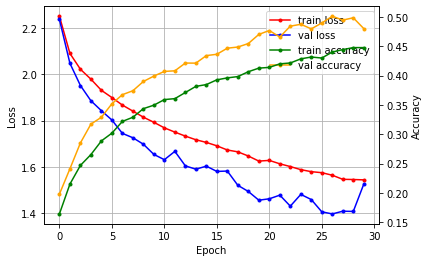

StratifiedKFold fold:2/2
train_N=25000, val_N=25000
fold:2 epoch:1/30 [tra]loss:2.2487 acc:0.1606  [val]loss:2.0841 acc:0.2239  [time]total:16.91sec tra:14.63sec val:2.28sec
fold:2 epoch:2/30 [tra]loss:2.0902 acc:0.2150  [val]loss:2.0514 acc:0.2466  [time]total:16.87sec tra:14.70sec val:2.17sec
fold:2 epoch:3/30 [tra]loss:2.0314 acc:0.2381  [val]loss:1.9880 acc:0.2702  [time]total:16.93sec tra:14.73sec val:2.20sec
fold:2 epoch:4/30 [tra]loss:1.9824 acc:0.2613  [val]loss:1.8746 acc:0.3135  [time]total:16.80sec tra:14.62sec val:2.18sec
fold:2 epoch:5/30 [tra]loss:1.9384 acc:0.2871  [val]loss:1.8919 acc:0.3121  [time]total:17.02sec tra:14.73sec val:2.29sec
fold:2 epoch:6/30 [tra]loss:1.8867 acc:0.3042  [val]loss:1.7896 acc:0.3418  [time]total:17.26sec tra:15.03sec val:2.23sec
fold:2 epoch:7/30 [tra]loss:1.8690 acc:0.3133  [val]loss:1.7705 acc:0.3462  [time]total:17.17sec tra:15.00sec val:2.17sec
fold:2 epoch:8/30 [tra]loss:1.8391 acc:0.3272  [val]loss:1.7397 acc:0.3679  [time]total:16.88s

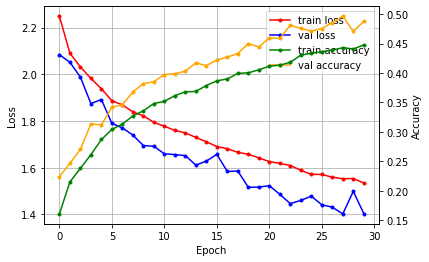

all folds score
total loss:1.464393, accuracy:0.483960
fold1/2 loss:1.525150, accuracy:0.480240
fold2/2 loss:1.403635, accuracy:0.487680

cross table


pred,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,2074,679,829,95,77,87,65,191,581,322
1,131,3458,30,57,5,41,138,150,95,895
2,329,269,1681,254,610,297,704,603,150,103
3,122,227,289,1205,193,947,1145,431,217,224
4,157,75,483,216,1772,103,1276,684,131,103
5,85,197,236,899,253,1765,649,612,173,131
6,35,127,179,156,192,69,3955,123,53,111
7,90,176,170,293,445,322,445,2798,64,197
8,583,686,94,85,38,72,34,74,2918,416


In [26]:
train_models, train_model_paths = train()

# Test

In [27]:
# test
def test(train_models):
    for model in train_models:
        model.eval()

    model_num = len(train_models)

    test_ds = torchvision.datasets.CIFAR10(root="./", train=False, download=True, transform=None)
    test_Xs = test_ds.data
    test_ys = np.array(test_ds.targets)

    dataset_test = CifarDataset(test_Xs, test_ys, transforms=transforms_val)
    dataloader_test = DataLoader(dataset_test, batch_size=512, num_workers=4, shuffle=False, pin_memory=True)

    preds = []
    correct = 0

    with torch.no_grad():
         for step, batch in enumerate(dataloader_test):
            Xs = batch[0].to(device) # image
            ys = batch[1]

            _preds = np.zeros([len(ys), 10])

            for model in train_models:
                model_preds = F.softmax(model(Xs), dim=1).detach().cpu().numpy()
                _preds += model_preds / model_num

            _preds = _preds.argmax(axis=1)

            preds.extend(_preds)

            correct += sum(ys.numpy() == _preds)

    #---
    # label x pred
    #---
    res_df = pd.DataFrame({"label":test_ys, "pred":preds})
    print()
    print("cross table")
    cross = pd.crosstab(res_df["label"], res_df["pred"])

    accuracy = correct / len(test_ys)
    print(f"accuracy = {accuracy:.4f} ({correct} / {len(test_ys)})")

    display(cross)


test(train_models)

Files already downloaded and verified

cross table
accuracy = 0.5056 (5056 / 10000)


pred,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,373,127,239,14,12,7,16,33,119,60
1,21,763,5,9,1,6,19,35,15,126
2,49,53,362,50,118,56,147,113,33,19
3,18,49,52,249,36,186,235,94,45,36
4,30,12,82,34,351,24,291,130,33,13
5,14,43,46,168,43,376,133,125,36,16
6,10,24,36,24,33,14,821,17,7,14
7,23,24,27,52,47,72,79,622,12,42
8,104,130,14,11,6,12,6,21,619,77
